In [14]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import galsim
from galsim.angle import radians, arcsec, degrees, AngleUnit
import numpy as np
import matplotlib.pylab as plt
import time
import sys

sys.path.append('/Users/andypark/Desktop/phd/batsim')

from astropy import wcs
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename

import batsim.pltutil as batplot
from batsim.stamp import Stamp
from batsim.transforms import WCSTransform 

import jax
import jax.numpy as jnp

In [2]:
wcsfile = "./eimage_00182850-0-i-R22_S11-det000.fits"
f = fits.open(wcsfile)
w = WCS(f[0].header)

# Galsim

In [3]:
wcs_g = galsim.GSFitsWCS(wcsfile)
skypos = wcs_g.toWorld(galsim.PositionI(0, 0))
skypos.ra.deg, skypos.dec.deg

(51.793908983991834, -40.26485572360853)

In [4]:
wcs_g = galsim.GSFitsWCS("./eimage_00182850-0-i-R22_S11-det000.fits")
skypos = wcs_g.toWorld(galsim.PositionD(3, 3))
skypos.ra.deg, skypos.dec.deg

(51.794199400833755, -40.26493631713106)

# Manual?

In [5]:
def get_radec(params, wcs):
    u, v = get_uv(params, wcs)
    # 4) turn u, v into ra, dec
    center = galsim.CelestialCoord(w.wcs.crval[0] * degrees, w.wcs.crval[1] * degrees)
    ra, dec = center.deproject_rad(u, v, "gnomonic")
    return ra, dec

In [6]:
def get_uv(params, w):
    x, y = params
    x -= w.wcs.crpix[0]
    y -= w.wcs.crpix[1] 

    f = 0
    for p in range(w.sip.a_order+1):
        for q in range(w.sip.a_order+1):
            f += w.sip.a[p, q] * jnp.power(x, p) * jnp.power(y, q)
    g = 0
    for p in range(w.sip.a_order+1):
        for q in range(w.sip.a_order+1):
            g += w.sip.b[p, q] * jnp.power(x, p) * jnp.power(y, q)

    x += f
    y += g
    u, v = w.wcs.cd @ jnp.array([x, y])
    factor = 1. * degrees / radians
    u *= -factor
    v *= factor
    return u, v

In [7]:
shape = (4096, 4004)
indx = np.arange(shape[0], dtype=float)
indy = np.arange(shape[1], dtype=float)
inds = np.meshgrid(indy, indx, indexing="ij")
coords = np.vstack([np.ravel(_) for _ in inds[::-1]]).T

In [15]:
dget_uv = jax.vmap(jax.jacfwd(get_uv, 0), in_axes=[0, None])(coords, w)

In [16]:
du_dxy, dv_dxy = dget_uv
du_dx, du_dy = du_dxy.T
dv_dx, dv_dy = dv_dxy.T
g1_fd = (dv_dy - du_dx) / (dv_dy + du_dx)
g1_fd = np.reshape(g1_fd, shape)
g2_fd = -(dv_dx + du_dy) / (dv_dy + du_dx)
g2_fd = np.reshape(g2_fd, shape)

Text(0.5, 0, 'g')

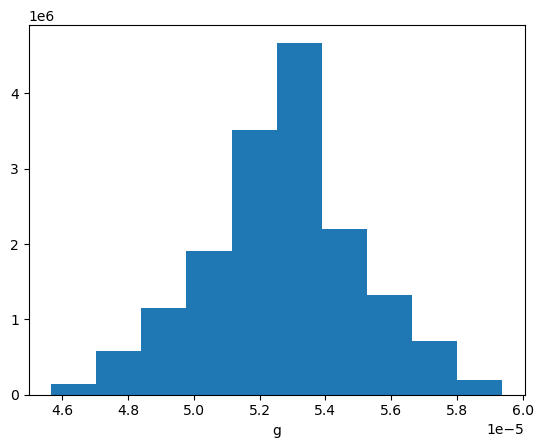

In [17]:
plt.hist(np.sqrt(g1_fd ** 2 + g2_fd ** 2).flatten())
plt.xlabel('g')

Text(0.5, 1.0, 'g2')

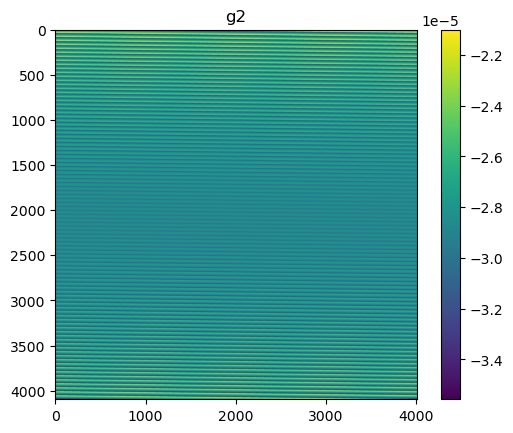

In [18]:
plt.imshow(g2_fd)
plt.colorbar()
plt.title('g2')

Text(0.5, 1.0, 'g1')

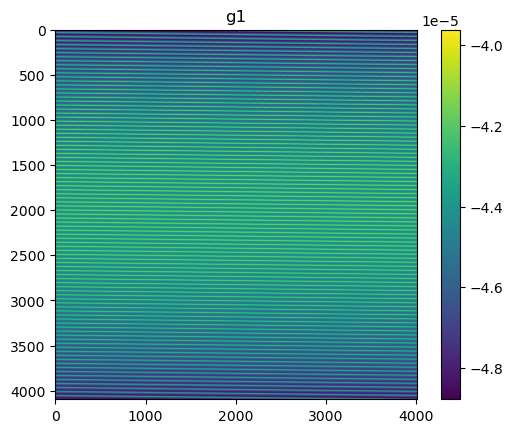

In [19]:
plt.imshow(g1_fd)
plt.colorbar()
plt.title('g1')

In [402]:
f = fits.open('./eimage_00182850-0-i-R22_S11-det000.fits')
w = WCS(f[0].header)

x, y = 0, 0

# 1) subtract off CRPIX
x -= w.wcs.crpix[0]
y -= w.wcs.crpix[1] 

# 2) SIP
w.sip.a[1, 0] += 1
w.sip.b[0, 1] += 1
f = 0
df_dx = 0
for p in range(w.sip.a_order+1):
    for q in range(w.sip.a_order+1):
        f += w.sip.a[p, q] * jnp.power(x, p) * jnp.power(y, q)
        df_dx += p * w.sip.a[p, q] * jnp.power(x, p-1) * jnp.power(y, q)
        
g = 0
dg_dx = 0
for p in range(w.sip.a_order+1):
    for q in range(w.sip.a_order+1):
        g += w.sip.b[p, q] * jnp.power(x, p) * jnp.power(y, q)
        dg_dx += p * w.sip.b[p, q] * jnp.power(x, p-1) * jnp.power(y, q)

x += f
y += g

# 3) Apply CD
u, v = w.wcs.cd @ np.array([x, y])
print(u, v)
factor = 1. * degrees / radians
u *= -factor
v *= factor

# 4) turn u, v into ra, dec
center = galsim.CelestialCoord(w.wcs.crval[0] * degrees, w.wcs.crval[1] * degrees)
ra, dec = center.deproject_rad(u, v, "gnomonic")
ra *= radians / degrees

-0.30057231505740145 0.10471201071042818


In [378]:
u, v

(0.005245976538093384, 0.0018275693532805385)

In [284]:
f = 0
for p in range(w.sip.a_order+1):
    for q in range(w.sip.a_order+1):
        f += w.sip.a[p, q] * jnp.power(u, p) * jnp.power(v, q)
g = 0
for p in range(w.sip.a_order+1):
    for q in range(w.sip.a_order+1):
        g += w.sip.b[p, q] * jnp.power(u, p) * jnp.power(v, q)

In [339]:
import fitsio

In [352]:
_, header = fitsio.read(wcsfile, header=True)

In [357]:
fits.open(wcsfile)[0].header.get("SIMPLE")

True

In [222]:
w.wcs.cd

array([[ 5.03166762e-05,  2.36139267e-05],
       [ 2.36110785e-05, -5.03122075e-05]])

In [266]:
from galsim.utilities import horner2d

In [263]:
def get_x(coords, wcs):
    u, v = coords
    u -= wcs.wcs.crpix[0]
    v -= wcs.wcs.crpix[1]
    f = 0
    for p in range(w.sip.a_order+1):
        for q in range(w.sip.a_order+1):
            f += w.sip.a[p, q] * jnp.power(u, p) * jnp.power(v, q)
    g = 0
    for p in range(w.sip.a_order+1):
        for q in range(w.sip.a_order+1):
            g += w.sip.b[p, q] * jnp.power(u, p) * jnp.power(v, q)
    v = jnp.array([u + f, v + g])
    x = wcs.wcs.cd @ v
    return x

In [264]:
get_x(coords, w)

Array([[-0.15075873, -0.15074867, -0.15073861, ..., -0.14984736,
        -0.1498373 , -0.14982724],
       [ 0.0525267 ,  0.05253142,  0.05253614, ...,  0.05218082,
         0.05218555,  0.05219027]], dtype=float32)